# Training and Evaluating ResNet Model
*by Marvin Bertin*
<img src="../../images/keras-tensorflow-logo.jpg" width="400">

# Import

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

2023-07-24 16:15:24.451332: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 16:15:24.500401: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 16:15:24.502463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 16:15:25.705901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
models = tf.keras.models
layers = tf.keras.layers
initializers = tf.keras.initializers
regularizers = tf.keras.regularizers
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image

# ResNet Model

In [3]:
def residual_block(input_tensor, filters, stage, reg=0.0, use_shortcuts=True):

    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'merge' + str(stage)

    # 1x1 conv
    # batchnorm-relu-conv
    # from input_filters to bottleneck_filters
    if stage>1: # first activation is just after conv1
        x = layers.BatchNormalization(name=bn_name+'a')(input_tensor)
        x = layers.Activation('relu', name=relu_name+'a')(x)
    else:
        x = input_tensor

    x = layers.Convolution2D(
            filters[0], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name=conv_name+'a'
        )(x)

    # 3x3 conv
    # batchnorm-relu-conv
    # from bottleneck_filters to bottleneck_filters
    x = layers.BatchNormalization(name=bn_name+'b')(x)
    x = layers.Activation('relu', name=relu_name+'b')(x)
    x = layers.Convolution2D(
            filters[1], (3,3),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias = False,
            name=conv_name+'b'
        )(x)

    # 1x1 conv
    # batchnorm-relu-conv
    # from bottleneck_filters  to input_filters
    x = layers.BatchNormalization(name=bn_name+'c')(x)
    x = layers.Activation('relu', name=relu_name+'c')(x)
    x = layers.Convolution2D(
            filters[2], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            name=conv_name+'c'
        )(x)

    # merge output with input layer (residual connection)
    if use_shortcuts:
        x = layers.add([x, input_tensor], name=merge_name)

    return x

In [4]:
def ResNetPreAct(input_shape=(32,32,3), nb_classes=5, num_stages=5,
                 use_final_conv=False, reg=0.0):


    # Input
    img_input = layers.Input(shape=input_shape)

    #### Input stream ####
    # conv-BN-relu-pool
    x = layers.Convolution2D(
            128, (3,3), strides=(2, 2),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name='conv0'
        )(img_input)
    x = layers.BatchNormalization(name='bn0')(x)
    x = layers.Activation('relu', name='relu0')(x)
#     x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool0')(x)

    #### Residual Blocks ####
    # 1x1 conv: batchnorm-relu-conv
    # FxF conv: batchnorm-relu-conv
    # 1x1 conv: batchnorm-relu-conv
    for stage in range(1,num_stages+1):
        x = residual_block(x, [32,32,128], stage=stage, reg=reg)


    #### Output stream ####
    # BN-relu-(conv)-avgPool-softmax
    x = layers.BatchNormalization(name='bnF')(x)
    x = layers.Activation('relu', name='reluF')(x)

    # Optional final conv layer
    if use_final_conv:
        x = layers.Convolution2D(
                64, (3,3),
                padding='same',
                kernel_regularizer=regularizers.l2(reg),
                name='convF'
            )(x)
    
    pool_size = input_shape[0] / 2
    x = layers.AveragePooling2D((pool_size,pool_size),name='avg_pool')(x)

    x = layers.Flatten(name='flat')(x)
    x = layers.Dense(nb_classes, activation='softmax', name='fc10')(x)

    return models.Model(img_input, x, name='rnpa')

# Compile Model

In [12]:
def compile_model(model):
    
    # loss
    loss = losses.categorical_crossentropy
    
    # optimizer
    optimizer = optimizers.Adam(learning_rate=0.0001)
    
    # metrics
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    
    # compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)
    
    return model

# Image Preprocessing And Augmentation

In [13]:
train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [14]:
BASE_DIR = "/home/mhaque/Restech/Learning/temp"

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/train"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/validation"),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [15]:
model = ResNetPreAct(input_shape=(32, 32, 3), nb_classes=5, num_stages=5,
                     use_final_conv=False, reg=0.005)

model = compile_model(model)

# Train Model on Flower Dataset

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/10


2023-07-24 16:30:47.288210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 92/100 [==========================>...] - ETA: 3s - loss: 4.3349 - categorical_accuracy: 0.4944 - top_k_categorical_accuracy: 1.0000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1000 batches). You may need to use the repeat() function when building your dataset.


2023-07-24 16:31:29.567790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 50s 496ms/step - loss: 4.3349 - categorical_accuracy: 0.4944 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.6752 - val_categorical_accuracy: 0.2438 - val_top_k_categorical_accuracy: 1.0000


# Plot Accuracy And Loss Over Time

In [19]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

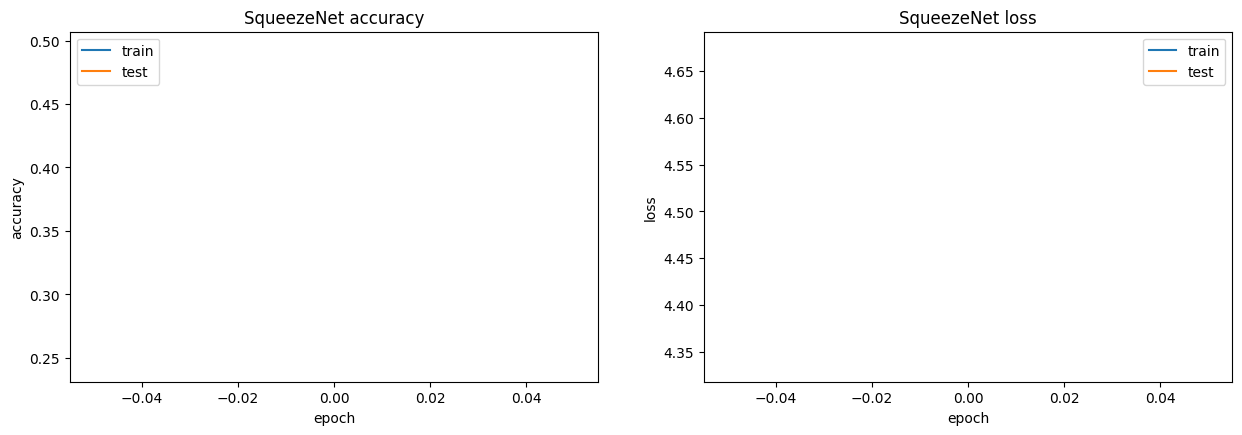

In [20]:
plot_accuracy_and_loss(history)

# Save Model Weights And Configuration

In [ ]:
# save model architecture
model_json = model.to_json()
open('resnet_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('image_classifier_resnet.h5', overwrite=True)

## Next Lesson
### Xception: Depthwise Separable Convolutions

<img src="../../images/divider.png" width="100">